In [1]:
#先輩のを模写してコードリーディング

In [140]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [141]:
class SimpleInitializer:
    
    def __init__(self, sigma):
        self.sigma = sigma
    
    def W(self, *shape):
        W = self.sigma * np.random.randn(*shape)
        return W
    
    def B(self, *shape):
        B = self.sigma * np.random.randn(*shape)
        return B

In [142]:
class SGD:
    
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return
    
class AdaGrad:
    
    def __init__(self, lr):
        self.lr = lr
        self.HW = 1
        self.HB = 1
        
    def update(self, layer):
        self.HW += layer.dW ** 2
        self.HB += layer.dB ** 2
        layer.W -= self.lr * np.sqrt(1 / self.HW) * layer.dW
        layer.B -= self.lr * np.sqrt(1 / self.HB) * layer.dB

# Ploblem 1.

In [ ]:

class SimpleConv1d:
    
    def __init__(self, filter_size, initializer, optimizer, pa=0):
        self.filter_size = filter_size
        self.optimizer = optimizer
        self.pa = pa
        self.W = initializer.W(filter_size)
        self.B = initializer.B(1)[0]
        self.n_out = None
        
    def forward(self, X):
        self.n_in = X.shape[-1]
        self.n_out = out_size(self.n_in, self.filter_size, self.pa)
        
        self.X = np.pad(X, ((self.filter_size-1), 0)) #1次元配列
        self.X1 = np.zeros((self.filter_size, self.n_in + (self.filter_size-1)))
        for i in range(self.filter_size):
            self.X1[i] = np.roll(self.X, -i)
        A = self.W @ self.X1[:, self.filter_size -1 - self.pa:self.n_in + self.pa] + self.B
        return A
    
    def backward(self, dA):
        
        self.dW = self.X1[:, self.filter_size -1 -self.pa:self.n_in + self.pa]@dA
        self.dB = np.sum(dA)
        self.dA = np.pad(dA, (0, (self.filter_size -1 )))
        self.dA1 = np.zeros((self.filter_size, self.dA.shape[-1]))
        for i in range(self.filter_size):
            self.dA1[i] = np.roll(self.dA, i)
        dX = self.W@self.dA1
        
        self.optimizer.update(self)
        return dX

# Problem 2.

In [144]:
def out_size(in_size, f, p=0, s=1):
    return int((in_size + 2*p-f) // s) + 1

# Problem 3.

In [145]:
simple_comv1d = SimpleConv1d(filter_size=3, initializer=SimpleInitializer(0.01), optimizer=SGD(0.01), pa=0)

In [146]:
x = np.array([1, 2, 3, 4])
simple_comv1d.W = np.array([3, 5, 7], dtype = float)
simple_comv1d.B = np.array([1], dtype = float)

In [147]:
a = simple_comv1d.forward(x)
a

array([35., 50.])

In [148]:
delta_a = np.array([10, 20])
delta_x = simple_comv1d.backward(delta_a)
delta_x

array([ 30., 110., 170., 140.])

In [149]:
delta_w = simple_comv1d.dW
delta_b = simple_comv1d.dB
delta_w, delta_b

(array([ 50.,  80., 110.]), 30)

# Ploblem 4.

In [150]:
class Conv1d:
    
    def __init__(self, filter_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0):
        self.filter_size = filter_size
        self.optimizer = optimizer
        self.pa = pa
        self.W = initializer.W(n_out_channels, n_in_channels, filter_size)
        self.B = initializer.B(n_out_channels)
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        self.n_out = None
        
    def forward(self, X):
        
        self.n_in = X.shape[-1]
        self.n_out = out_size(self.n_in, self.filter_size, self.pa)
        X = X.reshape(self.n_in_channels, self.n_in)
        self.X = np.pad(X, ((0, 0), ((self.filter_size-1), 0)))
        self.X1 = np.zeros((self.n_in_channels, self.filter_size, self.n_in + (self.filter_size -1)))
        for i in range(self.filter_size):
            self.X1[:, i] = np.roll(self.X, -i, axis = -1)
        A = np.sum(self.X1[:, :, self.filter_size -1 -self.pa:self.n_in + self.pa] * self.W[:, :, :, np.newaxis], axis =(1, 2)) + self.B.reshape(-1, 1)
        return A
    
    def backward(self, dA):
        
        self.dW = np.sum(np.dot(dA, self.X1[:, :, self.filter_size -1 -self.pa:self.n_in + self.pa, np.newaxis]), axis = -1)
        self.dB = np.sum(dA, axis =1)
        self.dA = np.pad(dA, ((0, 0), (0, (self.filter_size-1))))
        self.dA1 = np.zeros((self.n_out_channels, self.filter_size, self.dA.shape[-1]))
        for i in range(self.filter_size):
            self.dA1[:, i] = np.roll(self.dA, i, axis =-1)
        dX = np.sum(self.W@self.dA1, axis = 0)
        self.optimizer.update(self)
        return dX

In [151]:
conv1d = Conv1d(filter_size=3, initializer=SimpleInitializer(0.01), optimizer=SGD(0.01)
                , n_in_channels=2, n_out_channels=3, pa=0)

In [152]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
conv1d.W = np.ones((3, 2, 3), dtype=float) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。

conv1d.W[0,0,2] = 2
conv1d.W[0,1,0] = 2
conv1d.W[1,0,0] = 2

conv1d.B = np.array([1, 2, 3], dtype=float) # （出力チャンネル数）
conv1d.W

array([[[1., 1., 2.],
        [2., 1., 1.]],

       [[2., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.]]])

In [153]:
a = conv1d.forward(x)
a

array([[21., 29.],
       [18., 25.],
       [18., 24.]])

In [154]:
delta_a = np.array([[9, 11], [32, 35], [52, 56]])
delta_x = conv1d.backward(delta_a)
delta_x

array([[125., 230., 204., 113.],
       [102., 206., 195., 102.]])

In [155]:
delta_w = conv1d.dW
delta_b = conv1d.dB
delta_w, delta_b

(array([[[ 31.,  51.,  71.],
         [ 51.,  71.,  91.]],
 
        [[102., 169., 236.],
         [169., 236., 303.]],
 
        [[164., 272., 380.],
         [272., 380., 488.]]]),
 array([ 20,  67, 108]))

# Ploblem 5(Adv).
SimpleConv1dクラスとConmv1dクラスを変更

# Ploblem 6(Adv).

In [156]:
class Conv1d_2:
    
    def __init__(self, filter_size, initializer, optimizer, n_in_channels=1,n_out_channels=1,  pa=0):
        self.filter_size = filter_size
        self.optimizer = optimizer
        self.pa = pa
        self.W = initializer.W(n_out_channels, n_in_channels, filter_size)
        self.B = initializer.B(n_out_channels)
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        self.n_out = None
        
    def forward(self, X):
        
        self.n_samples = X.shape[0]
        self.n_in = X.shape[-1]
        self.n_out = out_size(self.n_in, self.filter_size, self.pa)
        X = X.reshape(self.n_samples, self.n_in_channels, self.n_in)
        self.X = np.pad(X, ((0, 0), (0, 0), ((self.filter_size-1), 0)))
        self.X1 = np.zeros((self.n_samples, self.n_in_channels, self.filter_size, self.n_in+(self.filter_size-1)))
        for i in range(self.filter_size):
            self.X1[:, :, i] = np.roll(self.X, -i, axis=-1)
        A = np.sum(self.X1[:, np.newaxis, :, :, self.filter_size-1-self.pa:self.n_in+self.pa]*self.W[:, :, :, np.newaxis],
                   axis =(2, 3)) + self.B.reshape(-1, 1)
        return A
    
    def backward(self, dA):
        
        self.dW = np.sum(dA[:, :, np.newaxis, np.newaxis]*self.X1[:, np.newaxis, :, :, self.filter_size-1-self.pa:self.n_in+self.pa],
                        axis=(0, -1))
        self.dB = np.sum(dA, axis=(0, -1))
        self.dA = np.pad(dA, ((0, 0), (0, 0), (0, (self.filter_size-1))))
        self.dA1 = np.zeros((self.n_samples, self.n_out_channels, self.filter_size, self.dA.shape[-1]))
        for i in range(self.filter_size):
            self.dA1[:, :, i] = np.roll(self.dA, i, axis =-1)
        dX = np.sum(self.W[:, :, :, np.newaxis]*self.dA1[:, :, np.newaxis], axis=(1, 3))
        self.optimizer.update(self)
        return dX

In [157]:
conv1d_2 = Conv1d_2(filter_size=3, initializer=SimpleInitializer(0.01)
                    , optimizer = SGD(0.01), n_in_channels=1, n_out_channels=1, pa=1)

In [158]:
x = np.array([[[1, 5, 0, 2, 8, 1]], [[1, 5, 0, 2, 8, 1]]])
conv1d_2.W = np.array([[[-1, 2, -1]]], dtype=float)
conv1d_2.B = np.array([0], dtype=float)

In [159]:
a = conv1d_2.forward(x)
a

array([[[-3.,  9., -7., -4., 13., -6.]],

       [[-3.,  9., -7., -4., 13., -6.]]])

In [160]:
delta_a = np.array([[[1, 2, 3, 4, 5, 6]], [[1, 2, 3, 4, 5, 6]]])
delta_x = conv1d_2.backward(delta_a)
delta_x

array([[[-1.,  0.,  0.,  0.,  0.,  0.,  7., -6.]],

       [[-1.,  0.,  0.,  0.,  0.,  0.,  7., -6.]]])

In [161]:
delta_w = conv1d_2.dW
delta_b = conv1d_2.dB
delta_w, delta_b

(array([[[150., 130.,  96.]]]), array([42]))

In [162]:
conv1d_2 = Conv1d_2(filter_size=3, initializer=SimpleInitializer(0.01), optimizer=SGD(0.01),
                    n_in_channels=2, n_out_channels=3, pa=0)

In [163]:
x = np.array([[[1, 2, 3, 4], [2, 3, 4, 5]]])
conv1d_2.W = np.ones((3, 2, 3), dtype=float)
conv1d_2.W[0, 0, 2]=2
conv1d_2.W[0, 1, 0]=2
conv1d_2.W[1, 0, 0]=2
conv1d_2.B=np.array([1, 2, 3], dtype=float)
conv1d_2.W

array([[[1., 1., 2.],
        [2., 1., 1.]],

       [[2., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.]]])

In [164]:
a = conv1d_2.forward(x)
a

array([[[21., 29.],
        [18., 25.],
        [18., 24.]]])

In [165]:
delta_a = np.array([[[9, 11], [32, 35], [52, 56]]])
delta_x = conv1d_2.backward(delta_a)
delta_x

array([[[125., 230., 204., 113.],
        [102., 206., 195., 102.]]])

In [166]:
delta_w = conv1d_2.dW
delta_b = conv1d_2.dB
delta_w, delta_b

(array([[[ 31.,  51.,  71.],
         [ 51.,  71.,  91.]],
 
        [[102., 169., 236.],
         [169., 236., 303.]],
 
        [[164., 272., 380.],
         [272., 380., 488.]]]),
 array([ 20,  67, 108]))

# Ploblem 7(Adv).

In [196]:
class Conv1d_3:
    
    def __init__(self,filter_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0, st=1):
        self.filter_size = filter_size
        self.optimizer = optimizer
        self.pa = pa
        self.st = st
        self.W = initializer.W(n_out_channels, n_in_channels, filter_size)
        self.B = initializer.B(n_out_channels)
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        self.n_out = None
        
    def forward(self, X):
        
        self.n_samples = X.shape[0]
        self.n_in = X.shape[-1]
        self.n_out = out_size(self.n_in, self.filter_size, self.pa, self.st)
        X = X.reshape(self.n_samples, self.n_in_channels, self.n_in)
        self.X = np.pad(X, ((0, 0), (0, 0), ((self.filter_size-1), 0)))
        self.X1 = np.zeros((self.n_samples, self.n_in_channels, self.filter_size, self.n_in+(self.filter_size-1)))
        for i in range(self.filter_size):
            self.X1[:, :, i]=np.roll(self.X, -i, axis =-1)
        A = np.sum(self.X1[:, np.newaxis, :, :, self.filter_size-1-self.pa:self.n_in+self.pa:self.st]*self.W[:, :, :, np.newaxis],
                  axis =(2, 3)) + self.B.reshape(-1, 1)
        return A
    
    def backward(self, dA):
        
        self.dW = np.sum(dA[:, :, np.newaxis, np.newaxis]*self.X1[:, np.newaxis, :, :, self.filter_size-1-self.pa:self.n_in+self.pa:self.st],
                        axis =(0, -1))
        self.dB = np.sum(dA, axis=(0, -1))
        self.dA = np.pad(dA, ((0, 0), (0, 0), (0, (self.filter_size-1))))
        self.dA1 = np.zeros((self.n_samples, self.n_out_channels, self.filter_size, self.dA.shape[-1]))
        for i in range(self.filter_size):
            self.dA1[:, :, i] = np.roll(self.dA, i, axis =-1)
        dX = np.sum(self.W[:, :, :, np.newaxis]*self.dA1[:, :, np.newaxis], axis=(1, 3))
        self.optimizer.update(self)
        return dX

In [197]:
conv1d_3 = Conv1d_3(filter_size=3, initializer=SimpleInitializer(0.01), optimizer=SGD(0.01), n_in_channels=1,
                    n_out_channels=1, pa=1, st=2)

In [198]:
x = np.array([[[1,5,0,2,8,1]]])
conv1d_3.W = np.array([[[-1, 2, -1]]], dtype=float)
conv1d_3.B = np.array([0], dtype=float)

In [199]:
a = conv1d_3.forward(x)
a

array([[[-3., -7., 13.]]])

In [200]:
delta_a = np.array([[[1,2,3]]])
delta_x = conv1d_3.backward(delta_a)
delta_x

array([[[-1.,  0.,  0.,  4., -3.]]])

In [201]:
delta_w = conv1d_3.dW
delta_b = conv1d_3.dB
delta_w, delta_b

(array([[[16., 25., 12.]]]), array([6]))

# Problem 8.

In [206]:
class Sigmoid:
    
    def forward(self, A):
        self.A = A
        return self.sigmoid(A)
    
    def backward(self, dZ):
        _sig = self.sigmoid(self.A)
        return dZ * (1 - _sig) * _sig
    
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))
    
class Tanh:
    
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        return dZ * (1 - (np.tanh(self.A)) ** 2)
    
class Softmax:
    
    def forward(self, X):
        self.Z = np.exp(X) / np.sum(np.exp(X), axis =1).reshape(-1, 1)
        return self.Z
    
    def backward(self, Y):
        self.loss = self.loss_func(Y)
        return self.Z - Y
    
    def loss_func(self, Y, Z=None):
        if Z is None:
            Z = self.Z
        return (-1)*np.average(np.sum(Y*np.log(Z), axis=1))
    
class ReLU:
    def forward(self, A):
        self.A = A
        return np.clip(A, 0, None)
    
    def backward(self, dZ):
        return dZ * np.clip(np.sign(self.A), 0, None)
    
class ScratchConvNeuralNetworkClassifier:
    
    def __init__(self, num_epoch=10, lr=0.01, batch_size=20, n_features=784, n_nodes1=400,
                n_nodes2=200, n_output=10, verbose=True, Activater=Tanh, Optimizer=AdaGrad):
        self.num_epoch = num_epoch
        self.lr = lr
        self.verbose = verbose
        
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        
        self.Activater = Activater
        if Activater == Sigmoid or Activater == Tanh:
            self.Initializer = XavierInitializer
        elif Activater == ReLU:
            self.Initializer = HeInitializer
        else:
            print('活性化関数が不適切')
        self.Optimizer = Optimizer
        
    def fit(self, X, y, X_val=None, y_val=None):
        
        self.val_enable = False
        if X_val is not None:
            self.val_enable = True
            
        self.conv1d_3 = Conv1d_3(filter_size=7, initializer=SimpleInitializer(0.01), optimizer=self.Optimizer(self.lr)
                                     , n_in_channels=1, n_out_channels=1, pa=3, st=2)
        self.conv1d_3.n_out = out_size(X.shape[-1], self.conv1d_3.filter_size, self.conv1d_3.pa, self.conv1d_3.st)
        self.activation1 = self.Activater()
        self.FC2 = FC(1 * self.conv1d_3.n_out, self.n_nodes2, self.Initializer(), self.Optimizer(self.lr))
        self.activation2 = self.Activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.Initializer(), self.Optimizer(self.lr))
        self.activation3 = Softmax()
            
        self.loss = []
        self.loss_epoch = [self.activation3.loss_func(y, self.forward_propagation(X))]
        for _ in range(self.num_epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            self.iter = len(get_mini_batch)
            for mini_X, mini_y in get_mini_batch:
                self.forward_propagation(mini_X)
                self.back_propagation(mini_X, mini_y)
                self.loss.append(self.activation3.loss)
            self.loss_epoch.append(self.activation3.loss_func(y, self.forward_propagation(X)))

        if self.verbose:
            self.learning_curve()
            print()
                
    def predict(self, X):
        return np.argmax(self.forward_propagation(X), axis=1)
        
    def forward_propagation(self, X):
        A1 = self.conv1d_3.forward(X)
        A1 = A1.reshape(A1.shape[0], A1.shape[-1])
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3
        
    def back_propagation(self, X, y_true):
        dA3 = self.activation3.backward(y_true)
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dA1 = dA1[:, np.newaxis]
        dZ0 = self.conv1d_3.backward(dA1)
            
    def learning_curve(self):
        plt.title('model loss')
        plt.xlabel('num_epoch')
        plt.ylabel('loss')
        plt.plot(np.arange(1, self.num_epoch*self.iter + 1), self.loss, label='train_loss')
        plt.plot(np.arange(0, self.num_epoch + 1)*self.iter, self.loss_epoch, label='epoch_loss')
        if self.val_enable:
            plt.plot(np.arange(1, self.num_epoch + 1), self.val_loss, label='val_loss')
        plt.legend()
        plt.show()
        return

class FC:
    
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        
    def forward(self, X):
        self.X=X
        A = X@self.W + self.B
        return A
        
    def backward(self,dA):
        dZ = dA@self.W.T
        self.dB = np.sum(dA, axis=0)
        self.dW = self.X.T@dA
        self.optimizer.update(self)
        return dZ
    
class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(1 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B
    
class HeInitializer():
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B
    
class GetMiniBatch:
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [203]:
def evaluate(y_true, y_pred):
    print("accuracy =", accuracy_score(y_true, y_pred))
    print("precision =", precision_score(y_true, y_pred, average='macro'))
    print("recall =", recall_score(y_true, y_pred, average='macro'))
    print("f1 =", f1_score(y_true, y_pred, average='macro'))
    print(confusion_matrix(y_true, y_pred))

In [204]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print("X_train.shape =", X_train_.shape) # (48000, 784)
print("X_val.shape =", X_val.shape) # (12000, 784)
print("y_train.shape =", y_train_.shape) # (48000, 784)
print("y_val.shape =", y_val.shape) # (12000, 784)

(60000, 28, 28)
(10000, 28, 28)
uint8
1.0
0.0
(60000,)
(60000, 10)
float64
X_train.shape = (48000, 784)
X_val.shape = (12000, 784)
y_train.shape = (48000, 10)
y_val.shape = (12000, 10)


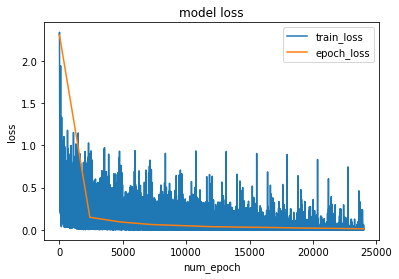

In [207]:
scratch_cnn1 = ScratchConvNeuralNetworkClassifier(num_epoch=10, lr=0.01, batch_size=20, 
                                                  n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, 
                                                  verbose=True, Activater=Tanh, Optimizer=SGD)
scratch_cnn1.fit(X_train_, y_train_)

In [208]:
y_pred1 = scratch_cnn1.predict(X_test)

In [209]:
evaluate(y_test, y_pred1)

accuracy = 0.976
precision = 0.976129862558046
recall = 0.9757276903529771
f1 = 0.9758954699227018
[[ 969    0    2    1    0    2    3    2    1    0]
 [   0 1131    1    0    1    1    1    0    0    0]
 [   7    5 1000    2    1    0    3    8    5    1]
 [   0    0    4  989    0    5    0    5    4    3]
 [   2    1    2    0  949    0    3    2    1   22]
 [   2    1    0    9    1  869    5    1    3    1]
 [   4    5    1    0    2    9  933    0    2    2]
 [   0   12   10    1    3    0    0  997    0    5]
 [   1    4    3    3    3    6    2    3  944    5]
 [   0    6    0    3    7    4    1    8    1  979]]
